loading data

In [9]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scipy
import os
import os.path as osp
import pickle
from sklearn.metrics import adjusted_rand_score
 

In [10]:
# for loading DLPFC12 data
def load_DLPFC(root_dir='/Users/zhuyuling/Desktop/Dataset/DLPFC12', section_id='151507'):
    # 151507, ..., 151676 
    # 12 in total, 7 layers
    # 151507: n_obs × n_vars = 4221 × 33538
    ad = sc.read_visium(path=os.path.join(root_dir, section_id), count_file=section_id+'_filtered_feature_bc_matrix.h5')
    ad.var_names_make_unique()

    gt_dir = os.path.join(root_dir, section_id, 'gt')
    gt_df = pd.read_csv(os.path.join(gt_dir, 'tissue_positions_list_GTs.txt'), sep=',', header=None, index_col=0)
    ad.obs['original_clusters'] = gt_df.loc[:, 6]
    keep_bcs = ad.obs.dropna().index
    ad = ad[keep_bcs].copy()
    ad.obs['original_clusters'] = ad.obs['original_clusters'].astype(int).astype(str)
    print("spot num", ad)
    return ad

# for loading mHypothalamus data
# already preprocessed? Xs are floats
def load_mHypothalamus(root_dir='/Users/zhuyuling/Desktop/Dataset/mHypothalamus', section_id='0.26'):
    # section id = '0.26', '0.21', '0.16', '0.11', '0.06', '0.01', '-0.04', '-0.09', '-0.14', '-0.19', '-0.24', '-0.29' 12 in total
    # cluster =     15      15      14      15      15      15      14       15       15       15      16        15
    # 9 clusters: ['BST' 'MPA' 'MPN' 'PV' 'PVH' 'PVT' 'V3' 'fx'] n_obs × n_vars = 5488 × 155
    info_file = os.path.join(root_dir, 'MERFISH_Animal1_info.xlsx')
    cnts_file = os.path.join(root_dir, 'MERFISH_Animal1_cnts.xlsx')
    xls_cnts = pd.ExcelFile(cnts_file)
    # print(xls_cnts.sheet_names)
    df_cnts = pd.read_excel(xls_cnts, section_id)
    
    xls_info = pd.ExcelFile(info_file)
    df_info = pd.read_excel(xls_info, section_id)
    # print(df_cnts, df_info)
    spatial_X = df_info.to_numpy()
    obs_ = df_info
    if len(df_info.columns) == 5:
        obs_.columns = ['psuedo_barcodes', 'x', 'y', 'original_clusters', 'Neuron_cluster_ID']
    elif len(df_info.columns) == 6:
        obs_.columns = ['psuedo_barcodes', 'x', 'y', 'cell_types', 'Neuron_cluster_ID', 'original_clusters']
    obs_.index = obs_['psuedo_barcodes'].tolist()
    # print(obs_)

    var_ = df_cnts.iloc[:, 0]
    var_ = pd.DataFrame(var_)
    # print(var_)
    
    ad = anndata.AnnData(X=df_cnts.iloc[:,1:].T, obs=obs_, var=var_)
    spatial = np.vstack((ad.obs['x'].to_numpy(), ad.obs['y'].to_numpy()))
    ad.obsm['spatial'] = spatial.T
    return ad
################fei added: layers of mHypothalamus: ['MPA' 'MPN' 'BST' 'fx' 'PVH' 'PVT' 'V3' 'PV']

In [25]:
DLPFC_layer_151508= load_DLPFC(root_dir='/Users/zhuyuling/Desktop/Dataset/DLPFC12', section_id='151508')
slices = {
    "DLPFC_151507" : DLPFC_layer_151508
}

/opt/anaconda3/envs/cellpose_1/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/cellpose_1/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4381 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [26]:
with open('/Users/zhuyuling/Desktop/Dataset/matrix_file2/barcodes.tsv','w') as f:
    for item in DLPFC_layer_151508.obs_names:
        f.write(item+'\n')
        

In [27]:
with open('/Users/zhuyuling/Desktop/Dataset/matrix_file2/features.tsv','w') as f:
    for item in ['\t'.join([x,x,'Gene Expression']) for x in DLPFC_layer_151508.var_names]:
        f.write(item+'\n')

In [28]:
from scipy import io
io.mmwrite('/Users/zhuyuling/Desktop/Dataset/matrix_file2/matrix',DLPFC_layer_151508.X.T)

In [29]:
!gzip matrix_file2/*

In [30]:
DLPFC_layer_151508.obs.to_csv('/Users/zhuyuling/Desktop/Dataset/metadata2.csv')

In [10]:
labels = []
labels.extend(DLPFC_layer_151508.obs['original_clusters'])

In [12]:
mHypothalamus=load_mHypothalamus(root_dir='/Users/zhuyuling/Desktop/Dataset/mHypothalamus', section_id='0.26')

/opt/anaconda3/envs/cellpose_1/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
mHypothalamus

AnnData object with n_obs × n_vars = 4832 × 155
    obs: 'psuedo_barcodes', 'x', 'y', 'original_clusters', 'Neuron_cluster_ID'
    var: 'Unnamed: 0'
    obsm: 'spatial'

alignment results:
1. save alignment matrix in .pkl file
2. calculate LAA & Ari and save in .csv file

alignment pairs:
for DLPFC: align the adjacent slices in the same samples e.g. 151507 and 151508, 151508 and 151509, etc
for mHypothalamus: align the adjacent slices: -0.04 and -0.09, -0.09 and -0.14, -0.14 and -0.19, -0.19 and -0.24
for simuData: align 151673 to each of the simData: e.g., 151673 and 100%, 151573 and 80%, ...
            align 151673 with 100%, 100% with 80%, 80% with 60%, 60% with 40%, 40% with 20% (the alignment results of this one is used to do 3D)

In [12]:
def cal_layer_based_alignment_result_mHypothalamus(alignment, s1, s2):
    #fei added
    labels = []
    labels.extend(s1.obs['original_clusters'])
    labels.extend(s2.obs['original_clusters'])

    res = []
    #l_dict = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6}
    cnt0 = 0
    ir = 0
    max_smallerThan0 = []
    sum_smallerThan0 = []
    min_smallerThan0 = []
    
    for i, elem in enumerate(alignment):
        #if np.sum(elem)>0:
        if np.max(elem) - np.min(elem) != 0:
            if labels[i] == labels[elem.argmax() + alignment.shape[0]]:
                cnt0 += 1
             
        else:
            ir += 1
            max_smallerThan0.append(np.max(elem))
            sum_smallerThan0.append(np.sum(elem))
            min_smallerThan0.append(np.min(elem))
    print("the number of sum alignment equals 0:", str(ir))
    if len(sum_smallerThan0)>0:
        print("sum in sum alignment equals 0 is between", np.min(sum_smallerThan0), np.max(sum_smallerThan0))
        print("max in sum alignment equals 0 is between", np.min(max_smallerThan0), np.max(max_smallerThan0))
        print("min in sum alignment equals 0 is between", np.min(min_smallerThan0), np.max(min_smallerThan0))
    #print(alignment.shape[0])
    #print(cnt0/alignment.shape[0], cnt1/alignment.shape[0], cnt2/alignment.shape[0], cnt3/alignment.shape[0], cnt4/alignment.shape[0], cnt5/alignment.shape[0], cnt6/alignment.shape[0])
    #res.extend([cnt0/alignment.shape[0], cnt1/alignment.shape[0], cnt2/alignment.shape[0], cnt3/alignment.shape[0], cnt4/alignment.shape[0], cnt5/alignment.shape[0], cnt6/alignment.shape[0]])
    #res.extend([cnt0, cnt1, cnt2, cnt3, cnt4, cnt5, cnt6])
    res.extend([cnt0])
    return res
def cal_paste_paste2_lba(dataset, s1, s2):
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment_res', dataset, dataset+'_AlignmentPi.pkl')
    #alignment=np.load(osp.join(input, method_path, file_name+"_"+method_path+"_AlignmentPi.npy"))
    #map_path = osp.join(input, method_path, file_name +'_'+dataset+'_AlignmentPi.pkl')
    with open(map_path, 'rb') as f:
        ali_o = pickle.load(f)
    
    lba = cal_layer_based_alignment_result_mHypothalamus(ali_o, s1, s2)
    sub_lba = [element/s1.shape[0] for element in lba]  
    return sub_lba
 
'''
section_ids_list=[['-0.04','-0.09'],['-0.09','-0.14'],['-0.14','-0.19'],['-0.19','-0.24']]
df=pd.DataFrame()
for section_ids in section_ids_list:
    dataset = section_ids[0] + '_' + section_ids[1]
   
    slice1 = load_mHypothalamus(section_id=section_ids[0])
    slice2 = load_mHypothalamus(section_id=section_ids[1])
    
    laa=cal_paste_paste2_lba(dataset,slice1,slice2,)
    df2=pd.DataFrame({
        dataset:laa
    })
    df = pd.concat([df,df2],ignore_index=False,axis=1)
df.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment_res/mHypothalamus_LAA.csv')
'''
# Ari
#calculate Ari
def compute_alignment_ari(sliceA, sliceB, pi):
    mapped_clusters = []
    for j in range(pi.shape[1]):
        mapping = pi[:, j]
        #original: if np.sum(mapping) > 0:
        if np.max(mapping) - np.min(mapping) != 0:
            i = np.argmax(mapping)
            mapped_clusters.append(sliceA.obs['original_clusters'][i])
        else:
            mapped_clusters.append("NULL")
    assert len(sliceB.obs['original_clusters']) == len(mapped_clusters)
    true_clusters_mapped_region = []
    mapped_clusters_mapped_region = []
    for i in range(len(sliceB.obs['original_clusters'])):
        if mapped_clusters[i] != "NULL":
            true_clusters_mapped_region.append(sliceB.obs['original_clusters'][i])
            mapped_clusters_mapped_region.append(mapped_clusters[i])

    ari = adjusted_rand_score(true_clusters_mapped_region, mapped_clusters_mapped_region)
    return ari

def cal_paste_paste2_ari(dataset,s1,s2):
    sub_ari=[]
        #alignment=np.load(osp.join(input, method_path, file_name+"_"+method_path+"_AlignmentPi.npy"))
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset, dataset+'_AlignmentPi.pkl')
    with open(map_path, 'rb') as f:
        ali_o = pickle.load(f)
         
    arI = compute_alignment_ari(s1, s2, ali_o)
    sub_ari.append(arI)
    return sub_ari

slices=[100,80,60,40,20]
slice1= sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5'))
     
df=pd.DataFrame()
for index in range(0,len(slices)):
    slice2 = sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(slices[index])+'__pseudocount_0_spotIndex.h5'))
     
    dataset='151673'+'_'+str(slices[index])
    ari=cal_paste_paste2_ari(dataset,slice1,slice2)
    df2=pd.DataFrame({
        dataset:ari
        })
    df = pd.concat([df,df2],ignore_index=False,axis=1)
print(df)
df.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment_res/simu_ARI.csv')

   151673_100  151673_80  151673_60  151673_40  151673_20
0    0.922583    0.39898   0.321958   0.319534   0.244411


In [12]:
df=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/alignment/mHypothalamus_5coord.csv')
 

3D
1. save other info. e.g., coor., cluster no,... in .csv file
2. save fig in .pdf file
3. save rotation degree, total distance, and distance per spot (this is for simulated data only) in .csv file

In [10]:
import pandas as pd
import pickle as pkl
from sklearn.metrics.pairwise import euclidean_distances
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv')
slice_1= df_1.loc[df_1['slice']==00,['X','Y']]
slices=[100,80,60,40,20]
for index in range(len(slices)):
    slice_2=df_1.loc[df_1['slice']==slices[index],['X','Y']]
    alignment=euclidean_distances(slice_1,slice_2)
    alignment = np.exp(-alignment)
    dataset='151673'+'_'+str(slices[index])
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset, dataset+'_AlignmentPi.pkl')
    if not os.path.exists(osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset)):
        os.makedirs(osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset))
    with open(map_path,'wb') as f:
        pkl.dump(alignment, f)

In [11]:
#calculate laywise bar, result needs to be devided by total number to calculate the accuracy rate
def cal_layer_based_alignment_result(alignment, s1, s2):
    #fei added
    labels = []
    labels.extend(s1.obs['original_clusters'])
    labels.extend(s2.obs['original_clusters'])

    res = []
    l_dict = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6}
    cnt0 = 0
    cnt1 = 0
    cnt2 = 0
    cnt3 = 0
    cnt4 = 0
    cnt5 = 0
    cnt6 = 0
    for i, elem in enumerate(alignment):
        if np.max(elem) - np.min(elem) != 0: # paste2 might have spots that are not aligned to any other spots. paste might have negative alignment
            if labels[i] == '-1' or labels[elem.argmax() + alignment.shape[0]] == '-1':
                continue
            if l_dict[labels[i]] == l_dict[labels[elem.argmax() + alignment.shape[0]]]:
                cnt0 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 1:
                cnt1 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 2:
                cnt2 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 3:
                cnt3 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 4:
                cnt4 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 5:
                cnt5 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 6:
                cnt6 += 1
    res.extend([cnt0, cnt1, cnt2, cnt3, cnt4, cnt5, cnt6])
    return res

def cal_paste_paste2_lba(dataset, s1, s2):
     
    #alignment=np.load(osp.join(input, method_path, file_name+"_"+method_path+"_AlignmentPi.npy"))
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset, dataset+'_AlignmentPi.pkl')
    with open(map_path, 'rb') as f:
        ali_o = pickle.load(f)
     
    lba = cal_layer_based_alignment_result(ali_o, s1, s2)
    sub_lba = [element/s1.shape[0] for element in lba]
    return sub_lba
slices=[100,80,60,40,20]
slice1= sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5'))
     
df=pd.DataFrame()
for index in range(0,len(slices)):
    slice2 = sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(slices[index])+'__pseudocount_0_spotIndex.h5'))
     
    dataset='151673'+'_'+str(slices[index])
    laa=cal_paste_paste2_lba(dataset,slice1,slice2)
    df2=pd.DataFrame({
        dataset:laa
        })
    df = pd.concat([df,df2],ignore_index=False,axis=1)
    #df.to_csv('DLPFC_LAA_151507.csv')
df.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment_res/simu_LAA.csv')

In [1]:
import ot
# 3. save rotation degree, total distance, and distance per spot (this is for simulated data only) in .csv file
## check if the authors provide rotation degree, if not, can use a similar way of line 174-180 in https://github.com/raphael-group/paste/blob/main/src/paste/visualization.py
# # to calculate the rotation matrix (Y: new coordinates, X: old coordinates, no need to use pi)
### covert rotation matrix R to degrees
def get_rotation_angle(R):
    # Extract the sine and cosine from the matrix
    cos_theta = R[0, 0]
    sin_theta = R[1, 0]
    
    # Compute the angle in radians
    theta = np.arctan2(sin_theta, cos_theta)
    
    # Convert the angle to degrees (optional)
    theta_deg = np.degrees(theta)
    
    return theta, theta_deg

spotDis = []
disPerSpot = []
coordinatesA =  df_1.loc[df_1['slice']==00,['CentroidX','CentroidY']]
for i in range(len(section_ids_list)-1):
    coordinatesB = new_slices[i+1].obsm['spatial_aligned'].copy()
    disMatrix = ot.dist(coordinatesA, coordinatesB, metric='euclidean')
    gt = pd.read_csv('/home/xiem6/0Data/simulated/DLPFC/forBenchMark_1203_2023/_overlap=' + section_ids_list[i+1].split('=')[-1].split('%')[0] +'%mapping_matrix_ground_truth_spotIndex.csv', index_col=0)
    gt = gt.to_numpy()
    s = (gt * disMatrix).sum()
    spotDis.append(s)
    disPerSpot.append(s/new_slices[i+1].shape[0])

# Correct calculation of gt_r_deg
gt_r_deg = [-1, -10.29, -17.48, -26.47, -38.3]

# Convert to a NumPy array and create DataFrame
r_array = np.array(localOT_deg)[:, np.newaxis]
df = pd.DataFrame(r_array, columns=["localOT_r_deg"])
df['pair'] = range(len(localOT_deg))

# Calculate absolute differences and add as a new column
differences = np.abs(np.array(localOT_deg) - np.array(gt_r_deg))
df['dif_gt'] = differences
df['totalspotDis'] = spotDis # distances between corresponding spots
df['dis_per_spot'] = disPerSpot # distances per spot

# Reorder columns
df = df[['pair', 'localOT_r_deg', 'dif_gt', 'totalspotDis', 'dis_per_spot']]

# Display the DataFrame without the index
print(df.to_string(index=False))

result_path = osp.join(output_dir, "localOT_3D_results.csv" )
df.to_csv(result_path, index=False, float_format="%.4f")

In [5]:
df=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/alignment/151507__151510coord.csv')
slice_1=df.loc[df['slice']==1,['X','Y']]
slice_1

,X,Y
0,2514.0,3276.0
1,8520.0,9178.0
2,2878.0,5133.0
3,9581.0,3462.0
4,7663.0,2779.0
...,...,...
4216,6239.0,7464.0
4217,9466.0,5045.0
4218,9703.0,4218.0
4219,7906.0,4017.0


In [16]:
adata=sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap=20__pseudocount_0_spotIndex.h5')
type(adata.obsm['spatial'])

numpy.ndarray

In [68]:
centroid_new=slice_1.loc[:,['CentroidX','CentroidY']]-np.mean(slice_1.loc[:,['CentroidX','CentroidY']],axis=0)

In [69]:
centroid_old=adata.obsm['spatial']-np.mean(adata.obsm['spatial'],axis=0)
centroid_new=slice_1.loc[:,['CentroidX','CentroidY']]-np.mean(slice_1.loc[:,['CentroidX','CentroidY']],axis=0)
H = centroid_new.T @ centroid_old
 
U, S, Vt = np.linalg.svd(H)
R = Vt.T.dot(U.T)
if np.linalg.det(R) < 0:
    Vt[-1, :] *= -1
    R = Vt.T @ U.T

print("Rotation matrix R:")
print(R)

Rotation matrix R:
[[ 0.97216325 -0.23430452]
 [ 0.23430452  0.97216325]]


In [28]:
import scanpy as sc
from scipy import io

section_ids=[20,40,60,80,100]
for index, section_id in enumerate(section_ids):
    path=osp.join('/Users/zhuyuling/Desktop/Dataset/simData', 'DLPFC_151673_overlap='+str(section_id) +'__pseudocount_0_spotIndex.h5')
    adata=sc.read_h5ad(path)
    print(adata)
    #adata.obs.to_csv(osp.join('/Users/zhuyuling/Desktop/Dataset/simData',str(section_id) +'__pseudocount','metadata.csv'))
    '''
    if not os.path.exists(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(section_id) +'__pseudocount')):
        os.makedirs(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(section_id) +'__pseudocount'))
    with open(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(section_id) +'__pseudocount','barcodes.tsv'),'w') as f:
        for item in adata.obs_names:
            f.write(item+'\n')
    with open(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(section_id) +'__pseudocount','features.tsv'),'w') as f:
        for item in ['\t'.join([x,x,'Gene Expression']) for x in adata.var_names]:
            f.write(item+'\n')
    io.mmwrite(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(section_id) +'__pseudocount','matrix'),adata.X.T)
    '''

AnnData object with n_obs × n_vars = 739 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters', 'SpotIndex'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 1447 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters', 'SpotIndex'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2180 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters', 'SpotIndex'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2894 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters', 'SpotIndex'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3596 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters', 'SpotIndex'
  

In [25]:
!gzip /Users/zhuyuling/Desktop/Dataset/simData/0__pseudocount/*

In [24]:
#path=osp.join('/Users/zhuyuling/Desktop/Dataset/simData', 'DLPFC_151673_overlap='+str(section_id) +'__pseudocount_0_spotIndex.h5')
adata=sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5')
#adata.obs.to_csv(osp.join('/Users/zhuyuling/Desktop/Dataset/simData','0' +'__pseudocount','metadata.csv'))
if not os.path.exists(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(0) +'__pseudocount')):
    os.makedirs(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(0) +'__pseudocount'))
adata.obs.to_csv(osp.join('/Users/zhuyuling/Desktop/Dataset/simData','0' +'__pseudocount','metadata.csv'))
with open(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(0) +'__pseudocount','barcodes.tsv'),'w') as f:
    for item in adata.obs_names:
        f.write(item+'\n')
with open(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(0) +'__pseudocount','features.tsv'),'w') as f:
    for item in ['\t'.join([x,x,'Gene Expression']) for x in adata.var_names]:
        f.write(item+'\n')
from scipy import io
io.mmwrite(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(0) +'__pseudocount','matrix'),adata.X.T)

In [26]:
!gzip -d /Users/zhuyuling/Desktop/Dataset/simData/0__pseudocount/metadata.csv.gz

In [6]:
import scanpy as sc
section_ids_list=[100,80,60,40,20]
data_1=sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5')
meta_data_1=data_1.obsm['spatial'] 
median_1=np.median(meta_data_1,axis=0)
#
result=pd.DataFrame(meta_data_1)
result=result.set_index(data_1.obs_names)
result = result.rename(columns={0: 'X', 1: 'Y'})
result['original_clusters']=data_1.obs['original_clusters']
result['slice']=00
#result['X']=data_1.obs_names
ds=pd.DataFrame()
ds = pd.concat([ds,result],axis=0)
for index,s in enumerate(section_ids_list):
    data_2=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(s)+'__pseudocount_0_spotIndex.h5'))
    meta_data_2=data_2.obsm['spatial'] 
    print(type(data_2.obsm['spatial'] ))
    median_2=np.median(meta_data_2,axis=0)
    result=meta_data_2-median_2+median_1
    result=pd.DataFrame(result)
    result=result.set_index(data_2.obs_names)
    result = result.rename(columns={0: 'X', 1: 'Y'})
    result['original_clusters']=data_2.obs['original_clusters']
    result['slice']=s
    #result['X']=data_2.obs_names
    ds = pd.concat([ds,result],axis=0)
ds.to_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [41]:
import numpy as np
import ot
from sklearn.metrics import pairwise 
def get_rotation_angle(R):
    # Extract the sine and cosine from the matrix
    cos_theta = R[0, 0]
    sin_theta = R[1, 0]

    # Compute the angle in radians
    theta = np.arctan2(sin_theta, cos_theta)

    # Convert the angle to degrees (optional)
    theta_deg = np.degrees(theta)

    return theta, theta_deg
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv',index_col=0)
localOT_deg=[]
section_ids_list=[100,80,60,40,20]
spotDis = []
disPerSpot = []
#coordinatesA = df_1.loc[df_1['slice']==00,:]
coordinatesA=sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5')
 
for i in range(len(section_ids_list)):
    coordinatesB=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(section_ids_list[i])+'__pseudocount_0_spotIndex.h5'))
    #coordinatesB = df_1.loc[df_1['slice']==section_ids_list[i+1],:]
    #desired=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(section_ids_list[i+1])+'__pseudocount_0_spotIndex.h5')).obs_names
    #coordinatesB.set_index('X', inplace=True)
    disMatrix = ot.dist(coordinatesA.obsm['spatial'],coordinatesB.obsm['spatial'], metric='euclidean')
    gt = pd.read_csv('/Users/zhuyuling/Desktop/Dataset/simData/_overlap=' + str(section_ids_list[i]) +'_mapping_matrix_ground_truth_spotIndex.csv', index_col=0)
    
    gt = np.array(gt,dtype=float)
    s = (gt * disMatrix).sum()
    spotDis.append(s)
    disPerSpot.append(s/coordinatesB.shape[0])
     
    #centroid_old=coordinatesA[['CentroidX','CentroidY']] -np.mean(coordinatesA[['CentroidX','CentroidY']] ,axis=0)
    centroid=coordinatesA[coordinatesB.obs_names,:] 
    centroid_=centroid.obsm['spatial']
    centroid_old=centroid_ -np.mean(centroid_ ,axis=0)
    centroid_old=np.array(centroid_old,dtype=float)
    
    centroid_new=coordinatesB.obsm['spatial'] -np.mean(coordinatesB.obsm['spatial'] ,axis=0)
    centroid_new=np.array(centroid_new,dtype=float)
    '''
    U, _, Vt = np.linalg.svd(np.dot(centroid_new.T, centroid_old))
    R = np.dot(U, Vt)
    
# Ensure R is a proper rotation matrix (det(R) should be 1)
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = np.dot(U, Vt)
    
    '''
    H = np.dot(centroid_new.T, centroid_old)
 
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(U, Vt)
     
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
        
    th,th_deg=get_rotation_angle(R)
    print(get_rotation_angle(R))
    localOT_deg.append(th_deg)

gt_r_deg = [-1, -10.29, -17.48, -26.47, -38.3]
# Convert to a NumPy array and create DataFrame
r_array = np.array(localOT_deg) 
df = pd.DataFrame(r_array, columns=["scHolography_r_deg"])
df['pair'] = range(len(localOT_deg))
differences = np.abs(np.array(localOT_deg) - np.array(gt_r_deg))
 
df['dif_gt'] = differences
df['totalspotDis'] = spotDis # distances between corresponding spots
df['dis_per_spot'] = disPerSpot # distances per spot
# Reorder columns
df = df[['pair', 'scHolography_r_deg', 'dif_gt', 'totalspotDis', 'dis_per_spot']]

# Display the DataFrame without the index
print(df.to_string(index=False))

(0.01731774360864456, 0.9922336194649892)
(0.17970966083497614, 10.296605103571599)
(0.30487293449327246, 17.467932434232928)
(0.46190922904205556, 26.465449342251457)
(0.6745659208496558, 38.64978026804122)
 pair  scHolography_r_deg    dif_gt  totalspotDis  dis_per_spot
    0            0.992234  1.992234  6.283127e+05    174.725440
    1           10.296605 20.586605  5.124952e+06   1770.888854
    2           17.467932 34.947932  6.460121e+06   2963.358081
    3           26.465449 52.935449  6.422338e+06   4438.381713
    4           38.649780 76.949780  4.717369e+06   6383.449436


In [40]:
coordinatesB.obs_names

Index(['TGACGATGCACTAGAA-1', 'TCGGGCACTTCTGGAT-1', 'CCACAATGTACGTCTT-1',
       'AAACAGAGCGACTCCT-1', 'CGAGCTGGGCTTTAGG-1', 'CACCTAATCAGTTTAC-1',
       'TGACATCGAGCGGACC-1', 'CGCGCCCGACTTAATA-1', 'GAACGTCTCATGGTCG-1',
       'AGCCCTAAGCGAAGTT-1',
       ...
       'TTCTTCGCAATAGAGC-1', 'TTCTTTGGTCGCGACG-1', 'TTGAAAGGTGTAAAGG-1',
       'TTGAGGCATTTAACTC-1', 'TTGATGTGTAGTCCCG-1', 'TTGCCGGTGATCCCTC-1',
       'TTGCGGCGACTCATGC-1', 'TTGCTGGCCGGGCTTC-1', 'TTGGATCGACTTCTGG-1',
       'TTGTATCACACAGAAT-1'],
      dtype='object', length=739)

In [49]:
import numpy as np
import ot
from sklearn.metrics import pairwise 
def get_rotation_angle(R):
    # Extract the sine and cosine from the matrix
    cos_theta = R[0, 0]
    sin_theta = R[1, 0]

    # Compute the angle in radians
    theta = np.arctan2(sin_theta, cos_theta)

    # Convert the angle to degrees (optional)
    theta_deg = np.degrees(theta)

    return theta, theta_deg
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv',index_col=0)
localOT_deg=[]
section_ids_list=[00,100,80,60,40,20]
spotDis = []
disPerSpot = []
coordinatesA = df_1.loc[df_1['slice']==00,:]
#desired_order=sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5').obs_names
#coordinatesA = coordinatesA.set_index('X').loc[desired_order].reset_index()
#coordinatesA.set_index('X', inplace=True)
coordinatesA_1 = sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5')
 
    #centroid_old=coordinatesA[['CentroidX','CentroidY']] -np.mean(coordinatesA[['CentroidX','CentroidY']] ,axis=0)
centroid_= coordinatesA_1.obsm['spatial']
     
centroid_old=centroid_ -np.mean(centroid_ ,axis=0)
centroid_old=np.array(centroid_old,dtype=float)
    
centroid_new=coordinatesA[['X','Y']] -np.mean(coordinatesA[['X','Y']] ,axis=0)
centroid_new=np.array(centroid_new,dtype=float)
H = np.dot(centroid_new.T, centroid_old)
 
U, S, Vt = np.linalg.svd(H)
R = np.dot(U, Vt)
     
if np.linalg.det(R) < 0:
    Vt[-1, :] *= -1
    R = Vt.T @ U.T
        
thA,thA_deg=get_rotation_angle(R)
print(thA_deg)
     
 
for i in range(len(section_ids_list)-1):
    coordinates_1 = df_1.loc[df_1['slice']==section_ids_list[i+1],:]
    #desired=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(section_ids_list[i+1])+'__pseudocount_0_spotIndex.h5')).obs_names
    #coordinatesB.set_index('X', inplace=True)
    coordinates_2=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(section_ids_list[i+1])+'__pseudocount_0_spotIndex.h5'))
    
    disMatrix = ot.dist(np.array(coordinatesA[['X','Y']]), np.array(coordinates_1[['X','Y']]), metric='euclidean')
    gt = pd.read_csv('/Users/zhuyuling/Desktop/Dataset/simData/_overlap=' + str(section_ids_list[i+1]) +'_mapping_matrix_ground_truth_spotIndex.csv', index_col=0)
    
    gt = np.array(gt,dtype=float)
    s = (gt * disMatrix).sum()
    spotDis.append(s)
    disPerSpot.append(s/coordinatesB.shape[0])
     
    #centroid_old=coordinatesA[['CentroidX','CentroidY']] -np.mean(coordinatesA[['CentroidX','CentroidY']] ,axis=0)
    centroid_= coordinates_2.obsm['spatial']
     
    centroid_old=centroid_ -np.mean(centroid_ ,axis=0)
    centroid_old=np.array(centroid_old,dtype=float)
    
    centroid_new=coordinates_1[['X','Y']] -np.mean(coordinates_1[['X','Y']] ,axis=0)
    centroid_new=np.array(centroid_new,dtype=float)
    '''
    U, _, Vt = np.linalg.svd(np.dot(centroid_new.T, centroid_old))
    R = np.dot(U, Vt)
    
# Ensure R is a proper rotation matrix (det(R) should be 1)
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = np.dot(U, Vt)
    
    '''
    H = np.dot(centroid_new.T, centroid_old)
 
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(U, Vt)
     
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
        
    th,th_deg=get_rotation_angle(R)
    print(get_rotation_angle(R))
    localOT_deg.append(th_deg)
 
gt_r_deg = [-1, -10.29, -17.48, -26.47, -38.3]
# Convert to a NumPy array and create DataFrame
r_array = np.array(localOT_deg) 
r_array=r_array-thA_deg
df = pd.DataFrame(r_array, columns=["scHolography_r_deg"])
df['pair'] = range(len(localOT_deg))
differences = np.abs(np.array(localOT_deg) - np.array(gt_r_deg))
 
df['dif_gt'] = differences
df['totalspotDis'] = spotDis # distances between corresponding spots
df['dis_per_spot'] = disPerSpot # distances per spot
# Reorder columns
df = df[['pair', 'scHolography_r_deg', 'dif_gt', 'totalspotDis', 'dis_per_spot']]

# Display the DataFrame without the index
print(df.to_string(index=False))
 

8.452524018928975e-16
(5.029656655121143e-18, 2.8817809873832814e-16)
(-2.0735094541420008e-17, -1.1880334050281176e-15)
(3.4021803638566265e-17, 1.9493057599126748e-15)
(-1.060444134120793e-17, -6.075897329452646e-16)
(-7.774601192554174e-18, -4.454518357307308e-16)
 pair  scHolography_r_deg  dif_gt  totalspotDis  dis_per_spot
    0       -5.570743e-16    1.00  3.122067e+05    422.471822
    1       -2.033286e-15   10.29  2.355264e+06   3187.095555
    2        1.104053e-15   17.48  3.243766e+06   4389.399811
    3       -1.452842e-15   26.47  3.177206e+06   4299.332069
    4       -1.290704e-15   38.30  2.322913e+06   3143.319705


In [28]:
coordinatesB[['X','Y']]-np.mean(coordinatesB[['X','Y']])

,X,Y
TGACGATGCACTAGAA-1,-1022.836761,2357.718325
TCGGGCACTTCTGGAT-1,-1022.836761,-3099.973769
CCACAATGTACGTCTT-1,-1022.836761,1171.263522
AAACAGAGCGACTCCT-1,552.663239,103.454199
CGAGCTGGGCTTTAGG-1,-1022.836761,-727.064163
...,...,...
TTGCCGGTGATCCCTC-1,1032.163239,-15.191281
TTGCGGCGACTCATGC-1,-63.836761,-2150.809927
TTGCTGGCCGGGCTTC-1,141.663239,-1083.000604
TTGGATCGACTTCTGG-1,-885.836761,-1676.228005


In [29]:
centroid_-np.mean(centroid_)

,X,Y
TGACGATGCACTAGAA-1,2853.577808,440.577808
TCGGGCACTTCTGGAT-1,-489.422192,-3777.422192
CCACAATGTACGTCTT-1,2172.577808,-523.422192
AAACAGAGCGACTCCT-1,2804.577808,-2315.422192
CGAGCTGGGCTTTAGG-1,943.577808,-1969.422192
...,...,...
TTGCCGGTGATCCCTC-1,3014.577808,-2673.422192
TTGCGGCGACTCATGC-1,887.577808,-3767.422192
TTGCTGGCCGGGCTTC-1,1708.577808,-3042.422192
TTGGATCGACTTCTGG-1,467.577808,-2811.422192


In [33]:
merged_df = pd.merge(centroid_, coordinatesB, left_index=True, right_index=True)
merged_df

,X_x,Y_x,X_y,Y_y,original_clusters,slice
TGACGATGCACTAGAA-1,9320.0,6907.0,5878.0,9258.555087,4,20
TCGGGCACTTCTGGAT-1,5977.0,2689.0,5878.0,3800.862992,1,20
CCACAATGTACGTCTT-1,8639.0,5943.0,5878.0,8072.100284,5,20
AAACAGAGCGACTCCT-1,9271.0,4151.0,7453.5,7004.290961,3,20
CGAGCTGGGCTTTAGG-1,7410.0,4497.0,5878.0,6173.772598,4,20
...,...,...,...,...,...,...
TTGCCGGTGATCCCTC-1,9481.0,3793.0,7933.0,6885.645480,3,20
TTGCGGCGACTCATGC-1,7354.0,2699.0,6837.0,4750.026835,2,20
TTGCTGGCCGGGCTTC-1,8175.0,3424.0,7042.5,5817.836157,3,20
TTGGATCGACTTCTGG-1,6934.0,3655.0,6015.0,5224.608756,3,20


In [22]:
centroid_-np.mean(centroid_,axis=0)

,X,Y
TGACGATGCACTAGAA-1,573.799729,2720.355886
TCGGGCACTTCTGGAT-1,-2769.200271,-1497.644114
CCACAATGTACGTCTT-1,-107.200271,1756.355886
AAACAGAGCGACTCCT-1,524.799729,-35.644114
CGAGCTGGGCTTTAGG-1,-1336.200271,310.355886
...,...,...
TTGCCGGTGATCCCTC-1,734.799729,-393.644114
TTGCGGCGACTCATGC-1,-1392.200271,-1487.644114
TTGCTGGCCGGGCTTC-1,-571.200271,-762.644114
TTGGATCGACTTCTGG-1,-1812.200271,-531.644114


In [10]:
np.array(coordinatesA[['CentroidX','CentroidY']])

array([[ 9791.,  8468.],
       [ 5769.,  2807.],
       [ 4068.,  9505.],
       ...,
       [ 4631.,  7831.],
       [ 5571., 11193.],
       [ 6317.,  3291.]])

In [123]:
adata=sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap=20__pseudocount_0_spotIndex.h5')

In [16]:
type(disMatrix[0,1])

numpy.float64

In [126]:
adata.obs['array_row']

TGACGATGCACTAGAA-1    37
TCGGGCACTTCTGGAT-1     2
CCACAATGTACGTCTT-1    29
AAACAGAGCGACTCCT-1    14
CGAGCTGGGCTTTAGG-1    17
                      ..
TTGCCGGTGATCCCTC-1    11
TTGCGGCGACTCATGC-1     2
TTGCTGGCCGGGCTTC-1     8
TTGGATCGACTTCTGG-1    10
TTGTATCACACAGAAT-1    12
Name: array_row, Length: 739, dtype: int64

In [105]:
adata_1=sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5')
adata_1[adata_1.obs_names=='TCGGGCACTTCTGGAT-1',:].obs['array_col']

TCGGGCACTTCTGGAT-1    46
Name: array_col, dtype: int64

In [118]:
th,th_deg=get_rotation_angle(R)
print(th)

-2.569657854812838


/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_71749/4009018895.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding['Z'] = index
/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_71749/4009018895.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip([0,1,2,3,4,5,6],cmap)))
/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_71749/4009018895.py:15: SettingWithCopyWarning: 
A value is trying to

[[9791.0 8468.0 0]
 [5769.0 2807.0 0]
 [4068.0 9505.0 0]
 ...
 [7042.5 5817.836157452255 5]
 [6015.0 5224.608755859915 5]
 [6563.0 5936.481637770723 5]]


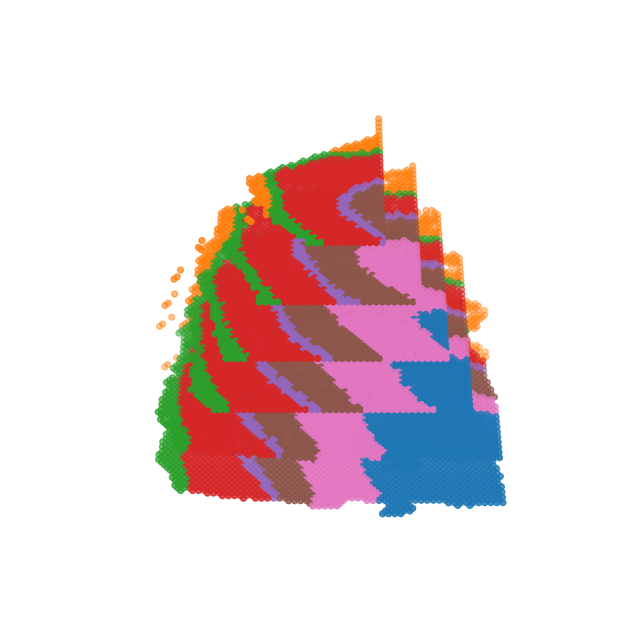

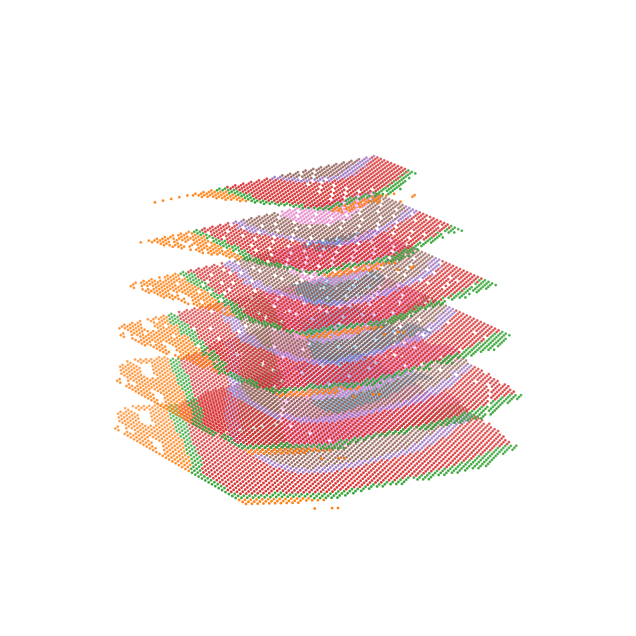

In [15]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from SPACEL import Scube
import os
cmap = []
for e in plt.get_cmap('tab10').colors:
    cmap.append(matplotlib.colors.rgb2hex(e))
coo = pd.DataFrame()
slice_id=[00,100,80,60,40,20]
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv',index_col=0)
 
for index, i in enumerate(slice_id):
    embedding=df_1.loc[df_1['slice'] == i,]
    embedding['Z'] = index
    embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip([0,1,2,3,4,5,6],cmap)))
    
    coo = pd.concat([coo,embedding],axis=0)
 
coo = coo[['X', 'Y','Z','original_clusters','celltype_colors','slice']]
coords=coo.values[:,:3]
# Reorder columns
coo['X'], coo['Z'] = coo['Z'], coo['X']
coo['X'], coo['Y'] = coo['Y'], coo['X']
coo['Z'] = -coo['Z']
print(coords)

 
coo.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment/Scube_outputs/scHolography_simu_aligned_coordinates_colors.csv')
'''
coords[:,[2, 0]] = coords[:,[0, 2]]
coords[:,[1, 0]] = coords[:,[0, 1]]
coords[:, 2] = -coords[:, 2]
'''
#2. save fig
fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=30, azim=90, frameon=False, show=True, s=18, return_fig=True) # Scube is from SPACEL

fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset', "scHolography_gtAndScube_simuData_3dviz_angle30_90_1122_24.pdf"), bbox_inches="tight")

fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=20, azim=-35, frameon=False, show=True, s=1, return_fig=True)

#fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset', "spacel_gtAndScube_mouse_3dviz_angle20_-35_upsidedown_0719_24.pdf"), bbox_inches="tight")

/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
         X     Y original_clusters   slice  Z celltype_colors
0     3276  2514                 1  151507  0         #ff7f0e
1     9178  8520                 3  151507  0         #d62728
2     5133  2878                 1  151507  0         #ff7f0e
3     3462  9581                 0  151507  0         #1f77b4
4     2779  7663                 6  151507  0         #e377c2
...    ...   ...               ...     ... ..             ...
4216  7464  6239                 3  151507  0         #d62728
4217  5045  9466                 6  151507  0         #e377c2
4218  4218  9703                 0  151507  0         #1f77b4
4219  4017  7906                 6  151507  0         #e377c2
4220  5683  3359                 1  151507  0         #ff7f0e

[4221 rows x 6 columns]


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4381 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
         X      Y original_clusters   slice  Z celltype_colors
0     9171   8586                 3  151508  1         #d62728
1     5127   2944                 1  151508  1         #ff7f0e
2     3454   9646                 0  151508  1         #1f77b4
3     8634   4273                 1  151508  1         #ff7f0e
4     2772   7728                 6  151508  1         #e377c2
...    ...    ...               ...     ... ..             ...
4376  5038   9531                 6  151508  1         #e377c2
4377  4211   9768                 6  151508  1         #e377c2
4378  4010   7971                 5  151508  1         #8c564b
4379  4963  11328                 0  151508  1         #1f77b4
4380  5677   3425                 1  151508  1         #ff7f0e

[4381 rows x 6 columns]


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4788 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
         X      Y original_clusters   slice  Z celltype_colors
0     9273   8648                 1  151509  2         #ff7f0e
1     5178   2965                 3  151509  2         #d62728
2     3507   9732                 6  151509  2         #e377c2
3     8720   4297                 3  151509  2         #d62728
4     2813   7798                 4  151509  2         #9467bd
...    ...    ...               ...     ... ..             ...
4783  5105   9612                 4  151509  2         #9467bd
4784  4271   9854                 5  151509  2         #8c564b
4785  4064   8041                 4  151509  2         #9467bd
4786  5034  11425                 6  151509  2         #e377c2
4787  5733   3449                 2  151509  2         #2ca02c

[4788 rows x 6 columns]


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4595 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
         X      Y original_clusters   slice  Z celltype_colors
0     9235   8703                 1  151510  3         #ff7f0e
1     3483   9743                 5  151510  3         #8c564b
2     8714   4364                 3  151510  3         #d62728
3     2805   7811                 4  151510  3         #9467bd
4     3079   8295                 4  151510  3         #9467bd
...    ...    ...               ...     ... ..             ...
4590  5075   9635                 4  151510  3         #9467bd
4591  4243   9870                 5  151510  3         #8c564b
4592  4049   8062                 3  151510  3         #d62728
4593  4993  11441                 6  151510  3         #e377c2
4594  5745   3499                 3  151510  3         #d62728

[4595 rows x 6 columns]
[[3276

/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/SPACEL/Scube/plot.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(loc[:,0], loc[:,1], loc[:,2],c=color,*args,**kwargs)


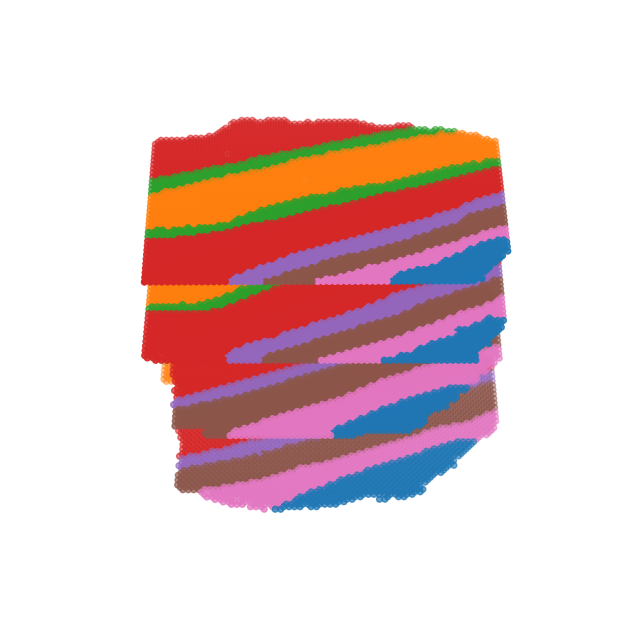

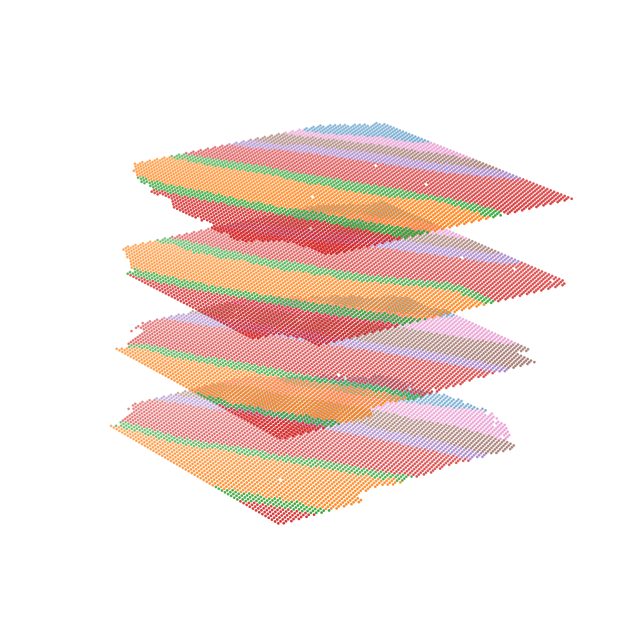

In [17]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from SPACEL import Scube
import os
cmap = []
for e in plt.get_cmap('tab10').colors:
    cmap.append(matplotlib.colors.rgb2hex(e))
coo = pd.DataFrame()
#slice_id=['151507','151508', '151509', '151510']
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv',index_col=0)
slice_id=[100,80,60,40,20]
for index, i in enumerate(slice_id):
    adata=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(i)+'__pseudocount_0_spotIndex.h5'))
    #adata=load_DLPFC(root_dir='/Users/zhuyuling/Desktop/Dataset/DLPFC12', section_id=i)
    embedding=pd.DataFrame(adata.obsm['spatial'])
    embedding.rename(columns={0: "X", 1: "Y"}, inplace=True)
    embedding['original_clusters']=adata.obs['original_clusters'].values
    embedding['slice']=i
    embedding['Z'] = index
    embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip(['0','1','2','3','4','5','6'],cmap)))
    print(embedding)
    coo = pd.concat([coo,embedding],axis=0)
 
coo = coo[['X', 'Y','Z','original_clusters','celltype_colors','slice']]
coords=coo.values[:,:3]
# Reorder columns
coo['X'], coo['Z'] = coo['Z'], coo['X']
coo['X'], coo['Y'] = coo['Y'], coo['X']
coo['Z'] = -coo['Z']
print(coords)

 
coo.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment/Scube_outputs/scHolography_simu_aligned_coordinates_colors.csv')
'''
coords[:,[2, 0]] = coords[:,[0, 2]]
coords[:,[1, 0]] = coords[:,[0, 1]]
coords[:, 2] = -coords[:, 2]
'''
#2. save fig
fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=30, azim=90, frameon=False, show=True, s=18, return_fig=True) # Scube is from SPACEL

fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset', "scHolography_gtAndScube_simuData_3dviz_angle30_90_1122_24.pdf"), bbox_inches="tight")

fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=20, azim=-35, frameon=False, show=True, s=1, return_fig=True)

In [33]:
import numpy as np
import ot
import pandas as pd
def get_rotation_angle(R):
    # Extract the sine and cosine from the matrix
    cos_theta = R[0, 0]
    sin_theta = R[1, 0]

    # Compute the angle in radians
    theta = np.arctan2(sin_theta, cos_theta)

    # Convert the angle to degrees (optional)
    theta_deg = np.degrees(theta)

    return theta, theta_deg
spotDis = []
disPerSpot = []
localOT_deg=[]
slice_id=[100,80,60,40,20]
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv',index_col=0)
coordinatesA=df_1.loc[df_1['slice'] == 00,['X','Y']]
print(coordinatesA)
for index, i in enumerate(slice_id):
    coordinatesB=df_1.loc[df_1['slice'] == i,['X','Y']]
     
    disMatrix = ot.dist(np.array(coordinatesA), np.array(coordinatesB), metric='euclidean')
    gt = pd.read_csv('/Users/zhuyuling/Desktop/Dataset/simData/_overlap=' + str(100) +'_mapping_matrix_ground_truth_spotIndex.csv',index_col=False)
    

    gt = gt.to_numpy()
    print(gt)
    s = (gt * disMatrix).sum()
    spotDis.append(s)
    disPerSpot.append(s/coordinatesB.shape[0]) 
     
    #centroid_old=coordinatesA[['CentroidX','CentroidY']] -np.mean(coordinatesA[['CentroidX','CentroidY']] ,axis=0)
    centroid_old=coordinatesA[['X','Y']] -np.mean(coordinatesA[['X','Y']] ,axis=0)
      
    centroid_new=coordinatesB[['X','Y']] -np.mean(coordinatesB[['X','Y']] ,axis=0)
    '''
    U, _, Vt = np.linalg.svd(np.dot(centroid_new.T, centroid_old))
    R = np.dot(U, Vt)

# Ensure R is a proper rotation matrix (det(R) should be 1)
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = np.dot(U, Vt)
 
    '''
    H = centroid_new.T @ centroid_old
 
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T.dot(U.T)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    
    th,th_deg=get_rotation_angle(R)
    localOT_deg.append(th_deg)
     
    '''
    P_pseudo_inverse = np.linalg.pinv(adata.obsm['spatial'])

# Calculate the rotation matrix
    R = np.dot(coordinatesB, P_pseudo_inverse)
    th,th_deg=get_rotation_angle(R)
    localOT_deg.append(th)
    '''
gt_r_deg = [-1, -10.29, -17.48, -26.47, -38.3]
 
# Convert to a NumPy array and create DataFrame
r_array = np.array(localOT_deg) 
df = pd.DataFrame(r_array, columns=["scHolography_r_deg"])
df['pair'] = range(len(localOT_deg))
differences = np.abs(np.array(localOT_deg) - np.array(gt_r_deg))
 
df['dif_gt'] = differences
df['totalspotDis'] = spotDis # distances between corresponding spots
df['dis_per_spot'] = disPerSpot # distances per spot

# Reorder columns
df = df[['pair', 'scHolography_r_deg', 'dif_gt', 'totalspotDis', 'dis_per_spot']]

# Display the DataFrame without the index
print(df.to_string(index=False))

                         X        Y
AAACAAGTATCTCCCA-1  9791.0   8468.0
AAACAATCTACTAGCA-1  5769.0   2807.0
AAACACCAATAACTGC-1  4068.0   9505.0
AAACAGAGCGACTCCT-1  9271.0   4151.0
AAACAGCTTTCAGAAG-1  3393.0   7583.0
...                    ...      ...
TTGTTTCACATCCAGG-1  5653.0   9396.0
TTGTTTCATTAGTCTA-1  4825.0   9630.0
TTGTTTCCATACAACT-1  4631.0   7831.0
TTGTTTGTATTACACG-1  5571.0  11193.0
TTGTTTGTGTAAATTC-1  6317.0   3291.0

[3611 rows x 2 columns]
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


ValueError: matrices are not aligned

                         X            Y  Z original_clusters celltype_colors
AAACAAGTATCTCCCA-1  9791.0  8468.000000  0                 3         #d62728
AAACAATCTACTAGCA-1  5769.0  2807.000000  0                 1         #ff7f0e
AAACACCAATAACTGC-1  4068.0  9505.000000  0                 0         #1f77b4
AAACAGAGCGACTCCT-1  9271.0  4151.000000  0                 3         #d62728
AAACAGCTTTCAGAAG-1  3393.0  7583.000000  0                 5         #8c564b
...                    ...          ... ..               ...             ...
TTGCCGGTGATCCCTC-1  5151.0  8843.855937  5                 3         #d62728
TTGCGGCGACTCATGC-1  4055.0  6708.237291  5                 2         #2ca02c
TTGCTGGCCGGGCTTC-1  4260.5  7776.046614  5                 3         #d62728
TTGGATCGACTTCTGG-1  3233.0  7182.819213  5                 3         #d62728
TTGTATCACACAGAAT-1  3781.0  7894.692095  5                 3         #d62728

[14467 rows x 5 columns]


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/SPACEL/Scube/plot.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(loc[:,0], loc[:,1], loc[:,2],c=color,*args,**kwargs)


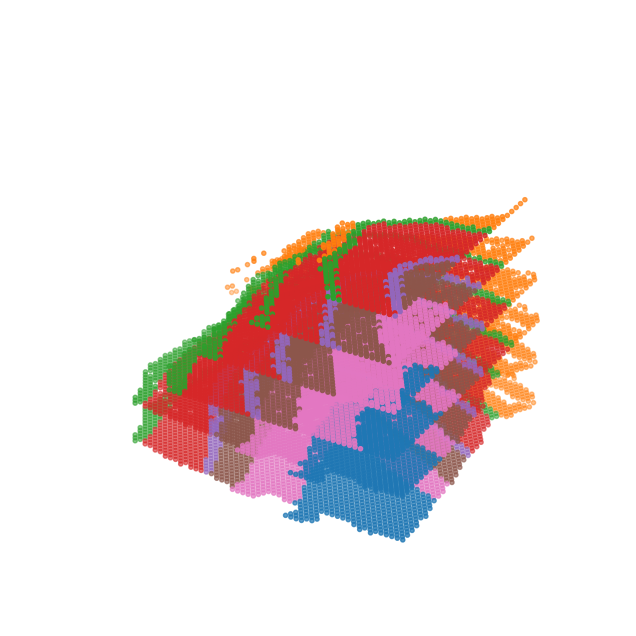

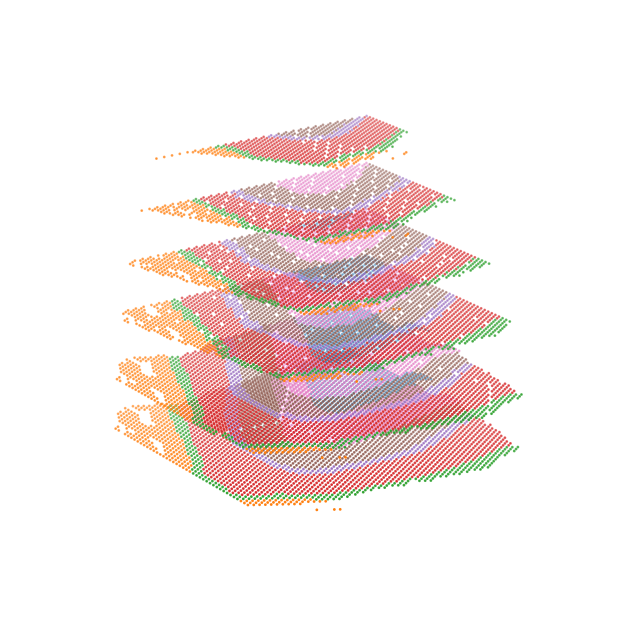

In [142]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from SPACEL import Scube
import os
cmap = []
for e in plt.get_cmap('tab10').colors:
    cmap.append(matplotlib.colors.rgb2hex(e))
coo = pd.DataFrame()
slice_id=[100,80,60,40,20]
adata=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5'))
embedding = adata.obsm['spatial'].copy()
embedding=pd.DataFrame(embedding).set_index(adata.obs_names)
embedding['Z'] = 0
embedding['original_clusters']=np.array(adata.obs['original_clusters']) 
embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip(['0','1','2','3','4','5','6'],cmap)))
 
embedding = embedding.rename(columns={0: "X",1: "Y"})
coo = pd.concat([coo,embedding],axis=0)

for index, i in enumerate(slice_id):
    adata=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(i)+'__pseudocount_0_spotIndex.h5'))
    embedding = adata.obsm['spatial'].copy()
    embedding=pd.DataFrame(embedding).set_index(adata.obs_names)
    embedding['Z'] = index+1
    embedding['original_clusters']=np.array(adata.obs['original_clusters'])
    embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip(['0','1','2','3','4','5','6'],cmap)))
    
    embedding = embedding.rename(columns={0: "X",1: "Y"})
    coo = pd.concat([coo,embedding],axis=0)
coords = coo.values[:,:3]
print(coo)
# Reorder columns
coo['X'], coo['Z'] = coo['Z'], coo['X']
coo['X'], coo['Y'] = coo['Y'], coo['X']
coo['Z'] = -coo['Z']
 
#coords = coo.values[:,:3]
 
#coo.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment/Scube_outputs/scHolography_simu_aligned_coordinates_colors.csv')
'''
coords[:,[2, 0]] = coords[:,[0, 2]]
coords[:,[1, 0]] = coords[:,[0, 1]]
coords[:, 2] = -coords[:, 2]
'''
#2. save fig
fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=30, azim=120, frameon=False, show=True, s=9, return_fig=True) # Scube is from SPACEL

#fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset', "scHolography_gtAndScube_mouse_3dviz_angle30_210_1122_24.pdf"), bbox_inches="tight")

fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=20, azim=-35, frameon=False, show=True, s=1, return_fig=True)

#fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset', "spacel_gtAndScube_mouse_3dviz_angle20_-35_upsidedown_0719_24.pdf"), bbox_inches="tight")

In [48]:
class Student:
    school='WashU'

    def __init__(self,name,age):
        self.name=name
        self.age=age 
    def show(self):
        print(f'my name is {self.name},I am {self.age} years old now')
stu=Student(name='zyl',age=18)
stu2=Student(name='julie',age=20)
print(Student.school)
stu2.gender='male'
print(stu2.name,stu2.age,stu2.gender)
def introduce():
    print('it is a dynamic language')
stu2.fun=introduce
stu2.fun()

WashU
julie 20 male
it is a dynamic language


In [41]:
class Student:
    def __init__(self,name,age,gender):
        self._name=name
        self.__age=age
        self.gender=gender
    def _fun(self):
        print('son and self can be used')

    def __fun1(self):
        print('private')
    def show(self):
        self._fun()
        self.__fun1()
        print(self._name)
        print(self.__age)

stu=Student(name='zyl',age=18,gender='female')
stu._Student__fun1()
print(stu._Student__age)

private
18


In [44]:
class Student():
    def __init__(self,name,gender):
        self.name=name
        self.__gender=gender
    @property
    def gender(self):
        return self.__gender
    @gender.setter
    def gender(self,value):
        if value !='male' and value !='female':
            print('error')
            self.__gender='male'
        else:
            self.__gender=value

stu=Student(name='zyl',gender='female')
stu.gender='female'

In [47]:
class Person:
    def __init__(self,name,age):
        self.name=name
        self.age=age
    def show(self):
        print(f'my name is {self.name}')
class Student(Person):
    def __init__(self,name,age,num):
        super().__init__(name,age)
        self.num=num
class Doctor(Person):
    def __init__(self,name,age,department):
        super().__init__(name,age)
        self.department=department

#####
stu=Student(name='zyl',age=18,num=10108)
stu.show()

my name is zyl


In [50]:
class FatherA():
    def __init__(self,name):
        self.name=name
    def showA(self):
        print('Method in Father A')
class FatherB():
    def __init__(self,age):
        self.age=age 
    def showB(self):
        print('Method in Father B')

class son(FatherA,FatherB):
    def __init__(self,name,age,gender):
        FatherA.__init__(self,name)
        FatherB.__init__(self,age)
        self.gender=gender
child=son(name='zyl',age=18,gender='female')
child.showA()

Method in Father A
